# Credit Card Fraud Detection
## Open-ended Lab

#### In this Lab you will utilize your machine learning (ML) modeling skills by using classification model of your choice to recognize fraudulent credit card transactions

You will use a real dataset to train each of these models. The dataset includes information about transactions made by credit cards in September 2013 by European cardholders. You will use the trained model to assess if a credit card transaction is legitimate or not.

<div id="Introduction">
    <h2>Introduction</h2>
    <br>Imagine that you work for a financial institution and part of your job is to build a model that predicts if a credit card transaction is fraudulent or not. You can model the problem as a binary classification problem. A transaction belongs to the positive class (1) if it is a fraud, otherwise it belongs to the negative class (0).
    <br>
    <br>You have access to transactions that occured over a certain period of time. The majority of the transactions are normally legitimate and only a small fraction are non-legitimate. Thus, typically you have access to a dataset that is highly unbalanced. This is also the case of the current dataset: only 492 transactions out of 284,807 are fraudulent (the positive class - the frauds - accounts for 0.172% of all transactions).
    <br>
    <br>To train the model you can use part of the input dataset and the remaining data can be used to assess the quality of the trained model. First, let's download the dataset.
    <br>
</div>


#### To get your kaggle credentials for download, follow the instructions here. http://bit.ly/kaggle-creds

In [24]:
# install the opendatasets package
!pip install opendatasets

import opendatasets as od

# download the dataset (this is a Kaggle dataset)
# during download you will be required to input your Kaggle username and password
od.download("https://www.kaggle.com/mlg-ulb/creditcardfraud")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Skipping, found downloaded files in "./creditcardfraud" (use force=True to force download)


<div id="import_libraries">
    <h2>Import Libraries</h2>
</div>


In [25]:
# Import the libraries we need to use in this lab
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score
import time
import warnings
warnings.filterwarnings('ignore')

<div id="dataset_analysis">
    <h2>Dataset Analysis</h2>
</div>

In this section you will read the dataset in a Pandas dataframe and visualize its content. You will also look at some data statistics. 
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html. 


In [26]:
# read the input data
raw_data = pd.read_csv('creditcardfraud/creditcard.csv')
print("There are " + str(len(raw_data)) + " observations in the credit card fraud dataset.")
print("There are " + str(len(raw_data.columns)) + " variables in the dataset.")

# display the first rows in the dataset
raw_data.head()

There are 284807 observations in the credit card fraud dataset.
There are 31 variables in the dataset.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In practice, a financial institution may have access to a much larger dataset of transactions. To simulate such a case, we will inflate the original one 10 times.


In [27]:
n_replicas = 10

# inflate the original dataset
big_raw_data = pd.DataFrame(np.repeat(raw_data.values, n_replicas, axis=0), columns=raw_data.columns)

print("There are " + str(len(big_raw_data)) + " observations in the inflated credit card fraud dataset.")
print("There are " + str(len(big_raw_data.columns)) + " variables in the dataset.")

# display first rows in the new dataset
big_raw_data.head()

There are 2848070 observations in the inflated credit card fraud dataset.
There are 31 variables in the dataset.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
2,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
3,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
4,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0


Each row in the dataset represents a credit card transaction. As shown above, each row has 31 variables. One variable (the last variable in the table above) is called Class and represents the target variable. Your objective will be to train a model that uses the other variables to predict the value of the Class variable. Let's first retrieve basic statistics about the target variable.

Note: For confidentiality reasons, the original names of most features are anonymized V1, V2 .. V28. The values of these features are the result of a PCA transformation ( dont worry about that for now) and are numerical. The feature 'Class' is the target variable and it takes two values: 1 in case of fraud and 0 otherwise. For more information about the dataset please visit this webpage: https://www.kaggle.com/mlg-ulb/creditcardfraud.


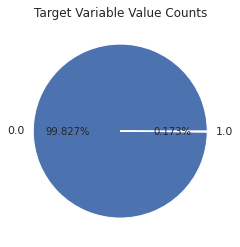

In [28]:
# get the set of distinct classes
labels = big_raw_data.Class.unique()

# get the count of each class
sizes = big_raw_data.Class.value_counts().values

# plot the class value counts
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.3f%%')
ax.set_title('Target Variable Value Counts')
plt.show()

As shown above, the Class variable has two values: 0 (the credit card transaction is legitimate) and 1 (the credit card transaction is fraudulent). Thus, you need to model a binary classification problem. Moreover, the dataset is highly unbalanced, the target variable classes are not represented equally. This case requires special attention when training or when evaluating the quality of a model. One way of handing this case at train time is to bias the model to pay more attention to the samples in the minority class. The models under the current study will be configured to take into account the class weights of the samples at train/fit time.



The credit card transactions have different amounts. plot a histogram that shows the distribution of these amounts? What is the range of these amounts (min/max)? 
print the percentiles of the amount values?


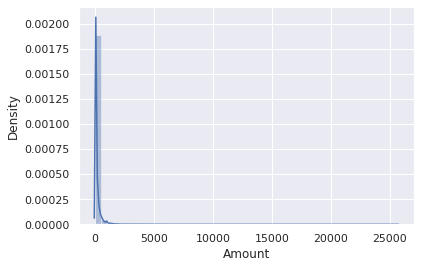

In [29]:
import seaborn as sns 
sns.distplot(big_raw_data['Amount'])

<div id="dataset_preprocessing">
    <h2>Dataset Preprocessing</h2>
</div>
In this subsection you will prepare the data for training. 


In [30]:
# data preprocessing such as scaling/normalization is typically useful for 
# linear models to accelerate the training convergence

# standardize features by removing the mean and scaling to unit variance
big_raw_data.iloc[:, 1:30] = StandardScaler().fit_transform(big_raw_data.iloc[:, 1:30])
data_matrix = big_raw_data.values

# X: feature matrix (for this analysis, we exclude the Time variable from the dataset)
X = data_matrix[:, 1:30]

# y: labels vector
y = data_matrix[:, 30]

# data normalization
X = normalize(X, norm="l1")

# print the shape of the features matrix and the labels vector
print('X.shape=', X.shape, 'y.shape=', y.shape)

X.shape= (2848070, 29) y.shape= (2848070,)


<div id="dataset_split">
    <h2>Dataset Train/Test Split</h2>
</div>
Now that the dataset is ready for building the classification models, you need to first divide the pre-processed dataset into a subset to be used for training the model (the train set) and a subset to be used for evaluating the quality of the model (the test set).


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)       
print('X_train.shape=', X_train.shape, 'Y_train.shape=', y_train.shape)
print('X_test.shape=', X_test.shape, 'Y_test.shape=', y_test.shape)

X_train.shape= (1993649, 29) Y_train.shape= (1993649,)
X_test.shape= (854421, 29) Y_test.shape= (854421,)


### removing class imbalance

In [31]:
# compute the sample weights to be used as input to the train routine so that 
# it takes into account the class imbalance present in this dataset
w_train = compute_sample_weight('balanced', y_train)

## Build a classifier

In [32]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

In [33]:
classifier = LogisticRegression()


## Discuss your findings below

In [41]:
classifier.fit(X_train, y_train)

LogisticRegression()

In [42]:
y_pred = classifier.predict(X_test)

In [43]:
accuracy = accuracy_score(y_test, y_pred)

In [44]:
print(accuracy)

0.9993141554339138


In [45]:
y_pred_train=classifier.predict(X_train)

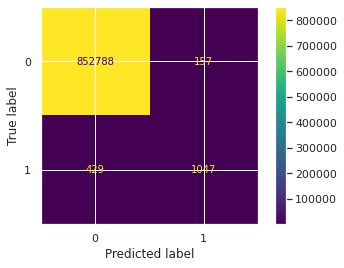

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

confusion_mat = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_mat, display_labels = [0, 1])
cm_display.plot()
plt.show()

In [47]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: {:.3f}".format(accuracy))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("F1 score: {:.3f}".format(f1))

Accuracy: 0.999
Precision: 0.870
Recall: 0.709
F1 score: 0.781
